In [1]:
from __future__ import division, print_function
import time
import torch.utils.data
from torchvision import transforms, datasets
import argparse
import matplotlib

import torchvision

import matplotlib.pyplot as plt

from __future__ import division
import numpy as np
import torch

import torch.nn.functional as F
import torch.nn as nn
import copy

from __future__ import print_function, division
import torch
from torch.autograd import Variable
from PIL import Image
import torch.utils.data as data
import numpy as np
import os
import sys
try:
    import cPickle as pickle
except:
    import pickle
    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import scipy.ndimage as ndim
import matplotlib.colors as mcolors
import pandas as pd
import time
import torch.utils.data
from torchvision import transforms, datasets
import torchvision
import argparse
import matplotlib

import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.optim import Optimizer

import collections
import h5py, sys
import gzip
import os
import math
import numpy as np
import pandas as pd

try:
    import cPickle as pickle
except:
    import pickle


import time
import torch.utils.data
from torchvision import transforms, datasets
import torchvision
import matplotlib

import time
import torch.utils.data
from torchvision import transforms, datasets
import argparse
import matplotlib

import torchvision

import matplotlib.pyplot as plt
import copy
from numpy.random import gamma

In [2]:

image_resize_size = 256
image_trans_size = 128
batch_size = 40
nb_epochs = 100

pSGLD = False
save_data = True
n_samples = 90

sample_freq = 2
burn_in = 1000



prior_sig = 0.1
# Where to save models weights
models_dir = 'models_SGHMC_COVID150'
# Where to save plots and error, accuracy vectors
results_dir = 'results_SGHMC_COVID150'

lr = 0.001

model= 'Gaussian_prior'
nsamples = int(n_samples)


## weight saving parameters #######


N_saves = 100
resample_its = 50
resample_prior_its = 15
re_burn = 1e8
###################################




## weight saving parameters #######

sim_steps = 5

###################################

Nsamples = nsamples

save_every = int(nb_epochs/20)  
# We sample every 2 epochs as I have found samples to be correlated after only 1
num_workers = 4
nhid = 1200

grad_std_mul=20

transform_covid19 = transforms.Compose([
    transforms.Resize(image_trans_size),
    transforms.CenterCrop(image_trans_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=1)
])

In [3]:

def load_object(filename):
    with open(filename, 'rb') as input:
        return pickle.load(input)


def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)


suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']


def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes) - 1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes)
    return '%s%s' % (f, suffixes[i])


def get_num_batches(nb_samples, batch_size, roundup=True):
    if roundup:
        return ((nb_samples + (-nb_samples % batch_size)) / batch_size)  # roundup division
    else:
        return nb_samples / batch_size


def generate_ind_batch(nb_samples, batch_size, random=True, roundup=True):
    if random:
        ind = np.random.permutation(nb_samples)
    else:
        ind = range(int(nb_samples))
    for i in range(int(get_num_batches(nb_samples, batch_size, roundup))):
        yield ind[i * batch_size: (i + 1) * batch_size]


def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out


def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()


def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)


class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

class DatafeedImage(data.Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        img = Image.fromarray(np.uint8(img))
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)


### functions for BNN with gauss output: ###

def diagonal_gauss_loglike(x, mu, sigma):
    # note that we can just treat each dim as isotropic and then do sum
    cte_term = -(0.5)*np.log(2*np.pi)
    det_sig_term = -torch.log(sigma)
    inner = (x - mu)/sigma
    dist_term = -(0.5)*(inner**2)
    log_px = (cte_term + det_sig_term + dist_term).sum(dim=1, keepdim=False)
    return log_px

def get_rms(mu, y, y_means, y_stds):
    x_un = mu * y_stds + y_means
    y_un = y * y_stds + y_means
    return torch.sqrt(((x_un - y_un)**2).sum() / y.shape[0])


def get_loglike(mu, sigma, y, y_means, y_stds):
    mu_un = mu * y_stds + y_means
    y_un = y * y_stds + y_means
    sigma_un = sigma * y_stds
    ll = diagonal_gauss_loglike(y_un, mu_un, sigma_un)
    return ll.mean(dim=0)


In [4]:


class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % self.lr, epoch)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch

In [5]:

class H_SA_SGHMC(Optimizer):
    """ Stochastic Gradient Hamiltonian Monte-Carlo Sampler that uses scale adaption during burn-in
        procedure to find some hyperparamters. A gaussian prior is placed over parameters and a Gamma
        Hyperprior is placed over the prior's standard deviation"""

    def __init__(self, params, lr=1e-2, base_C=0.05, gauss_sig=0.1, alpha0=10, beta0=10):

        self.eps = 1e-6
        self.alpha0 = alpha0
        self.beta0 = beta0

        if gauss_sig == 0:
            self.weight_decay = 0
        else:
            self.weight_decay = 1 / (gauss_sig ** 2)

        if self.weight_decay <= 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if base_C < 0:
            raise ValueError("Invalid friction term: {}".format(base_C))

        defaults = dict(
            lr=lr,
            base_C=base_C,
        )
        super(H_SA_SGHMC, self).__init__(params, defaults)

    def step(self, burn_in=False, resample_momentum=False, resample_prior=False):
        """Simulate discretized Hamiltonian dynamics for one step"""
        loss = None

        for group in self.param_groups:  # iterate over blocks -> the ones defined in defaults. We dont use groups.
            for p in group["params"]:  # these are weight and bias matrices
                if p.grad is None:
                    continue
                state = self.state[p]  # define dict for each individual param
                if len(state) == 0:
                    state["iteration"] = 0
                    state["tau"] = torch.ones_like(p)
                    state["g"] = torch.ones_like(p)
                    state["V_hat"] = torch.ones_like(p)
                    state["v_momentum"] = torch.zeros_like(
                        p)  # p.data.new(p.data.size()).normal_(mean=0, std=np.sqrt(group["lr"])) #
                    state['weight_decay'] = self.weight_decay

                state["iteration"] += 1  # this is kind of useless now but lets keep it provisionally

                if resample_prior:
                    alpha = self.alpha0 + p.data.nelement() / 2
                    beta = self.beta0 + (p.data ** 2).sum().item() / 2
                    gamma_sample = gamma(shape=alpha, scale=1 / (beta), size=None)
                    #                     print('std', 1/np.sqrt(gamma_sample))
                    state['weight_decay'] = gamma_sample

                base_C, lr = group["base_C"], group["lr"]
                weight_decay = state["weight_decay"]
                tau, g, V_hat = state["tau"], state["g"], state["V_hat"]

                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)

                # update parameters during burn-in
                if burn_in:  # We update g first as it makes most sense
                    tau.add_(-tau * (g ** 2) / (
                                V_hat + self.eps) + 1)  # specifies the moving average window, see Eq 9 in [1] left
                    tau_inv = 1. / (tau + self.eps)
                    g.add_(-tau_inv * g + tau_inv * d_p)  # average gradient see Eq 9 in [1] right
                    V_hat.add_(-tau_inv * V_hat + tau_inv * (d_p ** 2))  # gradient variance see Eq 8 in [1]

                V_sqrt = torch.sqrt(V_hat)
                V_inv_sqrt = 1. / (V_sqrt + self.eps)  # preconditioner

                if resample_momentum:  # equivalent to var = M under momentum reparametrisation
                    state["v_momentum"] = torch.normal(mean=torch.zeros_like(d_p),
                                                       std=torch.sqrt((lr ** 2) * V_inv_sqrt))
                v_momentum = state["v_momentum"]

                noise_var = (2. * (lr ** 2) * V_inv_sqrt * base_C - (lr ** 4))
                noise_std = torch.sqrt(torch.clamp(noise_var, min=1e-16))
                # sample random epsilon
                noise_sample = torch.normal(mean=torch.zeros_like(d_p), std=torch.ones_like(d_p) * noise_std)

                # update momentum (Eq 10 right in [1])
                v_momentum.add_(- (lr ** 2) * V_inv_sqrt * d_p - base_C * v_momentum + noise_sample)

                # update theta (Eq 10 left in [1])
                p.data.add_(v_momentum)

        return loss

In [6]:

class MLP(nn.Module):
    def __init__(self, input_dim, width, depth, output_dim):
        super(MLP, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.width = width
        self.depth = depth

        layers = [nn.Linear(input_dim, width), nn.ReLU()]
        for i in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(width, output_dim))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class BNN_cat(BaseNet):  # for categorical distributions
    def __init__(self, channels_in=1, side_in=224, classes=2, N_train = 300, lr=1e-2, cuda=True, grad_std_mul=30):
        super(BNN_cat, self).__init__()

        cprint('y', 'BNN categorical output')
        self.lr = lr
        self.channels_in = channels_in
        self.side_in = side_in
        self.classes = classes
        self.model = MLP(input_dim=self.channels_in * self.side_in * self.side_in, width=1200, depth=2, output_dim=self.classes)
        self.cuda = cuda

        self.N_train = N_train
        self.create_net()
        self.create_opt()
        self.schedule = None  # [] #[50,200,400,600]
        self.epoch = 0

        self.grad_buff = []
        self.max_grad = 1e20
        self.grad_std_mul = grad_std_mul

        self.weight_set_samples = []

    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)
        if self.cuda:
            self.model.cuda()

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        """This optimiser incorporates the gaussian prior term automatically. The prior variance is gibbs sampled from
        its posterior using a gamma hyper-prior."""
        self.optimizer = H_SA_SGHMC(params=self.model.parameters(), lr=self.lr, base_C=0.05, gauss_sig=0.1)  # this last parameter does nothing

    def fit(self, x, y, burn_in=False, resample_momentum=False, resample_prior=False):
        self.set_mode_train(train=True)
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)
        self.optimizer.zero_grad()
        out = self.model(x)
        loss = F.cross_entropy(out, y, reduction='mean')
        loss = loss * self.N_train  # We use mean because we treat as an estimation of whole dataset
        loss.backward()
        #print('len', len(self.grad_buff))
        #print([self.grad_buff[i].cpu() for i in range(len(self.grad_buff))])
        # Gradient buffer to allow for dynamic clipping and prevent explosions
        if len(self.grad_buff) > 1000:
            #self.grad_buff = [self.grad_buff[i].cpu() for i in range(len(self.grad_buff))]
            #print('len',len(self.grad_buff), self.grad_buff)
            #print(type(self.grad_buff))
            #print(np.array(self.grad_buff))

            self.max_grad = np.mean([self.grad_buff[i].cpu() for i in range(len(self.grad_buff))]) + self.grad_std_mul * np.std([self.grad_buff[i].cpu() for i in range(len(self.grad_buff))])
            self.grad_buff.pop(0)
        # Clipping to prevent explosions
        self.grad_buff.append(nn.utils.clip_grad_norm_(parameters=self.model.parameters(),
                                                       max_norm=self.max_grad, norm_type=2))
        if self.grad_buff[-1] >= self.max_grad:
            print(self.max_grad, self.grad_buff[-1])
            self.grad_buff.pop()
        self.optimizer.step(burn_in=burn_in, resample_momentum=resample_momentum, resample_prior=resample_prior)

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data * x.shape[0] / self.N_train, err

    def eval(self, x, y, train=False):
        self.set_mode_train(train=False)
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model(x)
        loss = F.cross_entropy(out, y, reduction='sum')
        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def save_sampled_net(self, max_samples):

        if len(self.weight_set_samples) >= max_samples:
            self.weight_set_samples.pop(0)

        self.weight_set_samples.append(copy.deepcopy(self.model.state_dict()))

        cprint('c', ' saving weight samples %d/%d' % (len(self.weight_set_samples), max_samples))
        return None

    def predict(self, x):
        self.set_mode_train(train=False)
        x, = to_variable(var=(x, ), cuda=self.cuda)
        out = self.model(x)
        probs = F.softmax(out, dim=1).data.cpu()
        return probs.data

    def sample_predict(self, x, Nsamples=0, grad=False):
        """return predictions using multiple samples from posterior"""
        self.set_mode_train(train=False)
        if Nsamples == 0:
            Nsamples = len(self.weight_set_samples)
        x, = to_variable(var=(x, ), cuda=self.cuda)

        if grad:
            self.optimizer.zero_grad()
            if not x.requires_grad:
                x.requires_grad = True

        out = x.data.new(Nsamples, x.shape[0], self.classes)

        # iterate over all saved weight configuration samples
        for idx, weight_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
            self.model.load_state_dict(weight_dict)
            out[idx] = self.model(x)

        out = out[:idx]
        prob_out = F.softmax(out, dim=2)

        if grad:
            return prob_out
        else:
            return prob_out.data

    def sample_eval(self, x, y, Nsamples=0, grad=False):
        #print('in sample_eval')
        """return predictions using multiple samples from posterior"""
        self.set_mode_train(train=False)
        if Nsamples == 0:
            #print('Nsamples=0')
            Nsamples = len(self.weight_set_samples)
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)
        
        
        if grad:
            print('grad')
            self.optimizer.zero_grad()
            if not x.requires_grad:
                x.requires_grad = True

        out = x.data.new(Nsamples, x.shape[0], self.classes)
        #print('momomomomo', len(self.weight_set_samples))
        # iterate over all saved weight configuration samples
        for idx, weight_dict in enumerate(self.weight_set_samples):

            if idx == Nsamples:
                break
            self.model.load_state_dict(weight_dict)
            #print('ccccccc', self.model, x.size()[0])
            #print('mmmmmmm', x.resize_(x.size()[0], self.side_in * self.side_in).size())
            out[idx] = self.model(x.resize_(x.size()[0], self.side_in * self.side_in))

        #print('idxxxxxxxxxx', idx)
        out = out[:idx]

        mean_out = F.softmax(out, dim=2).mean(dim=0, keepdim=False)

        loss = F.cross_entropy(mean_out, y, reduction='sum')
        prob_out = F.softmax(mean_out, dim=1).data.cpu()

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        if grad:
            return loss.data, err, prob_out
        else:
            return loss.data, err, prob_out

    def get_weight_samples(self, Nsamples=0):
        """return weight samples from posterior in a single-column array"""
        weight_vec = []

        if Nsamples == 0 or Nsamples > len(self.weight_set_samples):
            Nsamples = len(self.weight_set_samples)

        for idx, state_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break

            for key in state_dict.keys():
                if 'weight' in key:
                    weight_mtx = state_dict[key].cpu().data
                    for weight in weight_mtx.view(-1):
                        weight_vec.append(weight)

        return np.array(weight_vec)

    def save_weights(self, filename):
        save_object(self.weight_set_samples, filename)

    def load_weights(self, filename, subsample=1):
        self.weight_set_samples = load_object(filename)
        self.weight_set_samples = self.weight_set_samples[::subsample]

In [7]:


trainset = torchvision.datasets.ImageFolder(root="./notebooks/data/COVID/train", transform=transform_covid19)
valset = torchvision.datasets.ImageFolder(root="./notebooks/data/COVID/test", transform=transform_covid19)


channels_in = trainset[0][0].size()[0]
classes = np.shape(np.unique(trainset.targets))[0]

train_data_len = len(trainset.targets)
test_data_len = len(valset.targets)
use_cuda = torch.cuda.is_available()
NTrainPoints = train_data_len

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config


log_interval = 1

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

nb_its_dev = log_interval
flat_ims = True
# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

# load data

# data augmentation


use_cuda = torch.cuda.is_available()

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=num_workers)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=num_workers)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=num_workers)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=num_workers)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


Data:

Data:

Network:


In [8]:





########################################################################################


net = BNN_cat(channels_in = channels_in, side_in = image_trans_size, classes = classes, 
              N_train = NTrainPoints, lr = lr, cuda = use_cuda, grad_std_mul = grad_std_mul)



## ---------------------------------------------------------------------------------------------------------------------


# net dims
epoch = 0
it_count = 0
## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)
cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
best_cost = np.inf
best_err = np.inf

tic0 = time.time()
for i in range(epoch, nb_epochs):
    net.set_mode_train(True)
    tic = time.time()
    nb_samples = 0
    for x, y in trainloader:

        if flat_ims:
            x = x.view(x.shape[0], -1)

        cost_pred, err = net.fit(x, y, burn_in=(i % re_burn < burn_in),
                                 resample_momentum=(it_count % resample_its == 0),
                                 resample_prior=(it_count % resample_prior_its == 0))
        it_count += 1
        err_train[i] += err
        cost_train[i] += cost_pred
        nb_samples += len(x)

    cost_train[i] /= nb_samples
    err_train[i] /= nb_samples
    toc = time.time()

    # ---- print
    print("it %d/%d, Jtr_pred = %f, err = %f, " % (i, nb_epochs, cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))
    net.update_lr(i)

    # ---- save weights
    if i % re_burn >= burn_in and i % sim_steps == 0:
        net.save_sampled_net(max_samples=N_saves)
    #net.save_sampled_net(max_samples=N_saves)
    
    if i % sim_steps == 0:
        net.save_sampled_net(max_samples=N_saves)
    
    # ---- dev
    if i % nb_its_dev == 0:
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):
            if flat_ims:
                x = x.view(x.shape[0], -1)

            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))
        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir+'/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

## SAVE WEIGHTS
net.save_weights(models_dir + '/state_dicts.pkl')

#np.save(results_dir + '/cost_train.npy', pred_cost_train)
#np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)



Net:
BNN categorical output
    Total params: 21.11M

Train:


C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_3524/272664775.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


  init cost variables:


C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_3524/1161784216.py:63: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1050.)
  d_p.add_(weight_decay, p.data)


it 0/100, Jtr_pred = 0.704541, err = 0.510000,    time: 56.890023 seconds

 saving weight samples 1/100
    Jdev = 0.699331, err = 0.503333

best test error
Writting models_SGHMC_COVID150/theta_best.dat

it 1/100, Jtr_pred = 0.700707, err = 0.496500,    time: 55.600485 seconds

    Jdev = 0.672427, err = 0.405000

best test error
Writting models_SGHMC_COVID150/theta_best.dat

it 2/100, Jtr_pred = 0.681002, err = 0.443000,    time: 59.155406 seconds

    Jdev = 0.681616, err = 0.430000

it 3/100, Jtr_pred = 0.669175, err = 0.403500,    time: 56.556102 seconds

    Jdev = 0.693274, err = 0.413333

it 4/100, Jtr_pred = 0.660356, err = 0.389000,    time: 55.066005 seconds

    Jdev = 0.644438, err = 0.350000

best test error
Writting models_SGHMC_COVID150/theta_best.dat

it 5/100, Jtr_pred = 0.654714, err = 0.377500,    time: 55.281515 seconds

 saving weight samples 2/100
    Jdev = 0.660442, err = 0.398333

it 6/100, Jtr_pred = 0.667205, err = 0.408500,    time: 55.722930 seconds

    Jd

    Jdev = 0.953196, err = 0.320000

it 54/100, Jtr_pred = 0.663361, err = 0.266000,    time: 61.384748 seconds

    Jdev = 1.020263, err = 0.328333

it 55/100, Jtr_pred = 0.692348, err = 0.254000,    time: 75.343554 seconds

 saving weight samples 12/100
    Jdev = 1.051866, err = 0.311667

it 56/100, Jtr_pred = 0.673079, err = 0.246500,    time: 61.148101 seconds

    Jdev = 1.068652, err = 0.311667

it 57/100, Jtr_pred = 0.698693, err = 0.251000,    time: 57.160601 seconds

    Jdev = 1.026201, err = 0.321667

it 58/100, Jtr_pred = 0.695969, err = 0.254500,    time: 59.739826 seconds

    Jdev = 1.108938, err = 0.310000

it 59/100, Jtr_pred = 0.760707, err = 0.265000,    time: 58.322733 seconds

    Jdev = 1.131035, err = 0.290000

best test error
Writting models_SGHMC_COVID150/theta_best.dat

it 60/100, Jtr_pred = 0.741126, err = 0.256000,    time: 59.665227 seconds

 saving weight samples 13/100
    Jdev = 1.116799, err = 0.318333

it 61/100, Jtr_pred = 0.672665, err = 0.237500,  

In [9]:
save_object(net.weight_set_samples, models_dir+'/state_dicts.pkl')



In [10]:
net

In [11]:
## SAVE WEIGHTS
#net.save_weights(models_dir + '/state_dicts.pkl')

C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_3524/837431945.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(results_dir + '/err.png', bbox_extra_artists=(lgd,), box_inches='tight')


<Figure size 600x400 with 0 Axes>

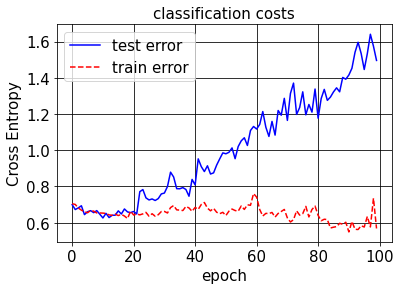

<Figure size 600x400 with 0 Axes>

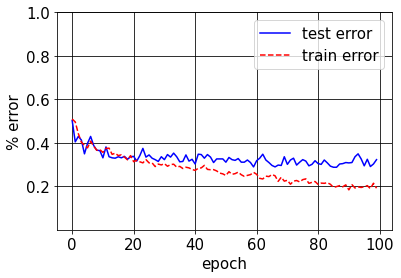

In [12]:

## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its

# fig cost vs its
textsize = 15
marker = 5

plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(range(0, nb_epochs, nb_its_dev), np.clip(cost_dev[::nb_its_dev], a_min=-5, a_max=5), 'b-')
ax1.plot(np.clip(cost_train, a_min=-5, a_max=5), 'r--')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.plot(range(0, nb_epochs, nb_its_dev), err_dev[::nb_its_dev], 'b-')
ax2.plot(err_train, 'r--')
ax2.set_ylim(top=1, bottom=1e-3)
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/err.png', bbox_extra_artists=(lgd,), box_inches='tight')
plt.show()


# predict

In [13]:
nb_samples = 0

In [14]:

trainset = torchvision.datasets.ImageFolder(root="./notebooks/data/COVID/train", transform=transform_covid19)
valset = torchvision.datasets.ImageFolder(root="./notebooks/data/COVID/test", transform=transform_covid19)

train_data_len = len(trainset.targets)
test_data_len = len(valset.targets)
use_cuda = torch.cuda.is_available()
NTrainPoints = train_data_len



mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config

log_interval = 1

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

nb_its_dev = log_interval
flat_ims = True
# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

# load data

# data augmentation


use_cuda = torch.cuda.is_available()

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=num_workers)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=num_workers)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=num_workers)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=num_workers)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


########################################################################################


net = BNN_cat(channels_in = channels_in, side_in = image_trans_size, classes = classes, 
              N_train = NTrainPoints, lr = lr, cuda = use_cuda, grad_std_mul = grad_std_mul)



with open(models_dir + '/state_dicts.pkl', 'rb') as input:
    net.weight_set_samples = pickle.load(input)

net.set_mode_train(False)
print(models_dir)
print('net', len(net.weight_set_samples))
test_cost = 0  # Note that these are per sample
test_err = 0

test_predictions = np.zeros((test_data_len, classes))



net.set_mode_train(False)

for j, (x, y) in enumerate(valloader):

    cost, err, probs = net.sample_eval(x, y, Nsamples, grad=False)  # , logits=True
    
    test_cost += cost
    test_err += err.cpu().numpy()
    test_predictions[nb_samples:nb_samples + len(x), :] = probs.numpy()
    nb_samples += len(x)

# test_cost /= nb_samples
test_err /= nb_samples
cprint('b', '    Loglike = %5.6f, err = %1.6f\n' % (-test_cost, test_err))








Data:

Data:

Network:

Net:
BNN categorical output
    Total params: 21.11M


C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_3524/272664775.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


models_SGHMC_COVID150
net 20
    Loglike = -350.909210, err = 0.246667



In [15]:
x_dev = []
y_dev = []
for x, y in valloader:
    x_dev.append(x.cpu().numpy())
    y_dev.append(y.cpu().numpy())

x_dev = np.concatenate(x_dev)
y_dev = np.concatenate(y_dev)
print(x_dev.shape)
print(y_dev.shape)

im_ind = np.random.randint(0, y_dev.shape[0])
# im_ind = 90
print("image number:", im_ind)

x, y = x_dev[im_ind], y_dev[im_ind]
#x_rot = np.expand_dims(ndim.interpolation.rotate(x[0, :, :], 0, reshape=False, cval=-0.42421296), 0)

print("real number:", y)

#plt.imshow(ndim.interpolation.rotate(x_dev[im_ind,0,:,:], 0, reshape=False))

ims = []

# ims.append(x_rot[:, :, :])
ims.append(x)

#ims = np.concatenate(ims)

net.set_mode_train(False)

y = np.ones(np.shape(ims)[0])*y
#ims = np.expand_dims(ims, axis=1)
ims = np.array(ims)

cost, err, probs = net.sample_eval(torch.from_numpy(ims), torch.from_numpy(y), Nsamples,
                                   grad=False)  # , logits=True

predictions = probs.numpy()

print("predictions", predictions)

print("error", err.cpu().numpy())

# predictions.max(axis=1)[0]
# selections = (predictions[:,i] == predictions.max(axis=1))
print("predict", predictions.argmax())

print(im_ind)

print(valset[im_ind][1])

print(valset.class_to_idx)



(600, 1, 128, 128)
(600,)
image number: 561
real number: 1
predictions [[0.3219868 0.6780132]]
error 0
predict 1
561
1
{'0noncovid': 0, '1covid': 1}


# predict train

In [16]:
torch.cuda.empty_cache()

In [17]:
x_train_dev = []
y_train_dev = []
for x, y in trainloader:
    x_train_dev.append(x.cpu().numpy())
    y_train_dev.append(y.cpu().numpy())

x_train_dev = np.concatenate(x_train_dev)
y_train_dev = np.concatenate(y_train_dev)

In [18]:
y_true = []
y_pred = []
prob = []
for i in range(0,train_data_len):
    x, y = x_train_dev[i], y_train_dev[i]
    
    #x_rot = np.expand_dims(ndim.interpolation.rotate(x[0, :, :], 0, reshape=False, cval=-0.42421296), 0)
    #print("real number:",y)
    y_true.append(y)
    #plt.imshow( ndim.interpolation.rotate(x_dev[im_ind,0,:,:], 0, reshape=False))
    #plt.show()
    ims=[]
    #ims.append(x_rot[:,:,:])
    ims.append(x)
    #ims = np.concatenate(ims)
    net.set_mode_train(False)
    #y = np.ones(ims.shape[0])*y
    y = np.ones(np.shape(ims)[0])*y
    #print(y)
    ims = np.array(ims)
    #ims = np.expand_dims(ims, axis=1)
    cost, err, probs = net.sample_eval(torch.from_numpy(ims), torch.from_numpy(y), Nsamples=Nsamples, grad=False) # , logits=True
    predictions = probs.numpy()
    prob.append(predictions)
#     print("predictions", predictions)
#     print("error", err.cpu().numpy())
    y_pred.append(predictions.argmax())
    torch.cuda.empty_cache()

print(y_pred)

prob = np.array(prob)
prob = prob.reshape(train_data_len, classes)

if save_data == True:
    save_path = 'SGHMC_predict_data'
    mkdir(save_path)
    file_name = "SGHMC_train_epochs=%d_lr=%f_batch_size=%d_image_trans_size=%d.csv" \
                % (nb_epochs, lr, batch_size, image_trans_size)
    completeName = os.path.join(save_path, file_name)
    print('c', completeName)
    if os.path.exists(completeName):
        os.remove(completeName)
    # df = pd.DataFrame(prob)
    # df.to_csv(completeName)
    np.savetxt(completeName, prob, delimiter=",")

[1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 

# predict test

In [19]:
torch.cuda.empty_cache()

In [20]:
y_true = []
y_pred = []
prob = []
for i in range(0,test_data_len):
    x, y = x_dev[i], y_dev[i]
    #x_rot = np.expand_dims(ndim.interpolation.rotate(x[0, :, :], 0, reshape=False, cval=-0.42421296), 0)
    #print("real number:",y)
    y_true.append(y)
    #plt.imshow( ndim.interpolation.rotate(x_dev[im_ind,0,:,:], 0, reshape=False))
    #plt.show()
    ims=[]
    #ims.append(x_rot[:,:,:])
    ims.append(x)
    #ims = np.concatenate(ims)
    net.set_mode_train(False)
    #y = np.ones(ims.shape[0])*y
    y = np.ones(np.shape(ims)[0])*y
    
    ims = np.array(ims)
    #ims = np.expand_dims(ims, axis=1)
    cost, err, probs = net.sample_eval(torch.from_numpy(ims), torch.from_numpy(y), Nsamples=Nsamples, grad=False) # , logits=True
    predictions = probs.numpy()
    prob.append(predictions)
#     print("predictions", predictions)
#     print("error", err.cpu().numpy())
    y_pred.append(predictions.argmax())
    torch.cuda.empty_cache()

print(y_pred)

prob = np.array(prob)
prob = prob.reshape(test_data_len, classes)

if save_data == True:
    save_path = 'SGHMC_predict_data'
    mkdir(save_path)
    file_name = "SGHMC_epochs=%d_lr=%f_batch_size=%d_image_trans_size=%d.csv" \
                % (nb_epochs, lr, batch_size, image_trans_size)
    completeName = os.path.join(save_path, file_name)
    print('c', completeName)
    if os.path.exists(completeName):
        os.remove(completeName)
    # df = pd.DataFrame(prob)
    # df.to_csv(completeName)
    np.savetxt(completeName, prob, delimiter=",")


[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 